## 네이버 영화리뷰 감성분석

In [91]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [10]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### Data loader
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [11]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [95]:
copied_data = train_data.copy()
copied_data[copied_data.duplicated()]

,id,document,label


In [96]:
copied_data[copied_data.isna( ).any(axis=1)]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [94]:
"""
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
"""
def preprocess(data):
    # 데이터의 중복 제거
    data = data.drop_duplicates()
    # NaN 결측치 제거
    data = data.dropna()
    
    tokenized=[]
    for sentence in data['document']:
        # 토큰화
        temp = tokenizer.morphs(sentence)
        # 불용어 제거
        temp = [word for word in temp if not word in stopwords]
        tokenized.append(temp)
        
    return tokenized

In [97]:
processed = preprocess(copied_data)
processed

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠',
  '.',
  '..',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '.',
  '...',
  '오버',
  '연기',
  '조차',
  '가볍',
  '지',
  '않',
  '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '스런',
  '연기',
  '돋보였',
  '던',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '너무나',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '3',
  '세',
  '부터',
  '초등',
  '학교',
  '1',
  '학년',
  '생',
  '인',
  '8',
  '살',
  '용',
  '영화',
  '.',
  'ㅋㅋㅋ',
  '.',
  '..',
  '별반',
  '개',
  '아까움',
  '.'],
 ['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.'],
 ['별',
  '반개',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '몇',
  '년',
  '인지',
  '.',
  '.',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '.',
  '감금',
  '만',
  '반복',
  '반복',
  '.',
  '.',
  '드라마',
  '가족',
  '없',
  '다

In [98]:
"""
- 사전word_to_index 구성
"""
def build_vocabulary(tokenized_texts, num_words=None):
    all_words = [word for text in tokenized_texts for word in text]
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(num_words)
    
    word_to_index = {
        '<PAD>': 0,  # 패딩용 단어
        '<BOS>': 1,  # 문장의 시작지점
        '<UNK>': 2   # 사전에 없는(Unknown) 단어
    }
    
    # 단어 추가
    for i, (word, _) in enumerate(most_common_words, start=len(word_to_index)):
        word_to_index[word] = i
    
    return word_to_index

In [99]:
dictionary = build_vocabulary(processed)
dictionary

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '.': 3,
 '영화': 4,
 '다': 5,
 '고': 6,
 '하': 7,
 '을': 8,
 '보': 9,
 '..': 10,
 '게': 11,
 ',': 12,
 '!': 13,
 '지': 14,
 '있': 15,
 '없': 16,
 '?': 17,
 '좋': 18,
 '나': 19,
 '었': 20,
 '만': 21,
 '는데': 22,
 '너무': 23,
 '봤': 24,
 '적': 25,
 '안': 26,
 '정말': 27,
 '로': 28,
 '음': 29,
 '것': 30,
 '아': 31,
 '네요': 32,
 '재밌': 33,
 '어': 34,
 '점': 35,
 '같': 36,
 '지만': 37,
 '진짜': 38,
 '했': 39,
 '에서': 40,
 '기': 41,
 '네': 42,
 '않': 43,
 '거': 44,
 '았': 45,
 '수': 46,
 '되': 47,
 '면': 48,
 'ㅋㅋ': 49,
 '말': 50,
 '연기': 51,
 '인': 52,
 '최고': 53,
 '주': 54,
 '내': 55,
 '~': 56,
 '평점': 57,
 '이런': 58,
 '어요': 59,
 '던': 60,
 '할': 61,
 '왜': 62,
 '1': 63,
 '겠': 64,
 '해': 65,
 '스토리': 66,
 '습니다': 67,
 'ㅋㅋㅋ': 68,
 '...': 69,
 '드라마': 70,
 '생각': 71,
 '아니': 72,
 '더': 73,
 '그': 74,
 '싶': 75,
 '사람': 76,
 '듯': 77,
 '감동': 78,
 '때': 79,
 '함': 80,
 '배우': 81,
 '본': 82,
 '까지': 83,
 '뭐': 84,
 '볼': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '감독': 89,
 '보다': 90,
 '라': 91,
 '재미': 92,
 '그냥': 93,
 '지루': 94,
 '시간': 95

In [100]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index.get(word, word_to_index['<UNK>']) for word in sentence_tokens]

def get_encoded_sentences(sentences, word_to_index):
    return [[word_to_index.get(word, word_to_index['<UNK>']) for word in text] for text in sentences]

In [101]:
encoded = get_encoded_sentences(processed, dictionary)
encoded

[[31, 73, 920, 3, 3, 38, 229, 19, 32, 751],
 [1021, 3, 10, 519, 548, 685, 4, 119, 3, 69, 1642, 51, 925, 1009, 14, 43, 390],
 [23, 204, 30123],
 [8427, 158, 3934, 3, 3, 297, 92, 16, 5, 3, 3, 57, 3484],
 [22688,
  8912,
  1107,
  51,
  2838,
  60,
  4,
  13,
  2765,
  40,
  1192,
  34,
  351,
  41,
  21,
  39,
  60,
  16074,
  22689,
  428,
  3103,
  1770,
  5],
 [675,
  22690,
  18670,
  130,
  419,
  184,
  1553,
  714,
  63,
  1698,
  705,
  52,
  375,
  192,
  267,
  4,
  3,
  68,
  3,
  10,
  2163,
  121,
  742,
  3],
 [254, 381, 8, 384, 2012, 55, 14, 818, 5, 3],
 [234,
  1457,
  140,
  5,
  425,
  755,
  10865,
  16075,
  51,
  1536,
  289,
  98,
  251,
  3,
  3,
  27,
  856,
  28,
  352,
  654,
  541,
  508,
  584,
  5,
  3326,
  3,
  8913,
  21,
  1462,
  1462,
  3,
  3,
  70,
  303,
  16,
  5,
  51,
  105,
  7,
  76,
  21,
  30124,
  42],
 [128, 16, 22, 92, 15, 289, 26, 47, 4],
 [62,
  657,
  57,
  240,
  763,
  17,
  573,
  85,
  10078,
  3,
  3,
  1486,
  636,
  738,
  80,
  2

In [102]:
target = copied_data['label']
target

0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 150000, dtype: int64

In [103]:
"""
1. 전처리
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
2. 어휘 사전 만들기
- 사전 word_to_index 구성
3. 인코딩
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
4. 타겟 값 추출
- X_train, y_train, X_test, y_test, word_to_index 리턴
"""
def my_load_data(train_data, test_data, num_words=10000):
    # 1. 전처리
    train_tokenized = preprocess(train_data)
    test_tokenized = preprocess(test_data)
    
    # 2. 어휘 사전 만들기
    word_to_index = build_vocabulary(train_tokenized)
    
    # 3. 인코딩
    X_train = get_encoded_sentences(train_tokenized, word_to_index)
    X_test = get_encoded_sentences(train_tokenized, word_to_index)
    
    # 4. 타겟 값 추출
    y_train = train_data['label']
    y_test = test_data['label']
    
    return X_train, y_train, X_test, y_test, word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [104]:
X_train, y_train, X_test, y_test, word_to_index

([[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
  [1028,
   4,
   11,
   519,
   549,
   687,
   5,
   120,
   4,
   70,
   1639,
   52,
   925,
   1006,
   15,
   44,
   391],
  [24, 205, 3],
  [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479],
  [3,
   8894,
   1108,
   52,
   2832,
   60,
   5,
   14,
   2758,
   41,
   1188,
   35,
   351,
   42,
   22,
   40,
   60,
   3,
   3,
   427,
   3102,
   1766,
   6],
  [675,
   3,
   3,
   131,
   420,
   185,
   1547,
   712,
   65,
   1694,
   715,
   53,
   375,
   192,
   271,
   5,
   4,
   69,
   4,
   11,
   2179,
   122,
   750,
   4],
  [253, 381, 9, 384, 2012, 55, 15, 817, 6, 4],
  [232,
   1450,
   144,
   6,
   425,
   756,
   3,
   3,
   52,
   1532,
   290,
   99,
   250,
   4,
   4,
   28,
   855,
   29,
   353,
   652,
   540,
   509,
   583,
   6,
   3318,
   4,
   8895,
   22,
   1460,
   1460,
   4,
   4,
   71,
   304,
   17,
   6,
   52,
   104,
   8,
   77,
   22,
   3,
   43],
  [128, 17, 23, 94, 16, 290, 27, 48

In [12]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [54]:
X_train, y_train, X_test, y_test, word_to_index

([[32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
  [1028,
   4,
   11,
   519,
   549,
   687,
   5,
   120,
   4,
   70,
   1639,
   52,
   925,
   1006,
   15,
   44,
   391],
  [24, 205, 3],
  [8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479],
  [3,
   8894,
   1108,
   52,
   2832,
   60,
   5,
   14,
   2758,
   41,
   1188,
   35,
   351,
   42,
   22,
   40,
   60,
   3,
   3,
   427,
   3102,
   1766,
   6],
  [675,
   3,
   3,
   131,
   420,
   185,
   1547,
   712,
   65,
   1694,
   715,
   53,
   375,
   192,
   271,
   5,
   4,
   69,
   4,
   11,
   2179,
   122,
   750,
   4],
  [253, 381, 9, 384, 2012, 55, 15, 817, 6, 4],
  [232,
   1450,
   144,
   6,
   425,
   756,
   3,
   3,
   52,
   1532,
   290,
   99,
   250,
   4,
   4,
   28,
   855,
   29,
   353,
   652,
   540,
   509,
   583,
   6,
   3318,
   4,
   8895,
   22,
   1460,
   1460,
   4,
   4,
   71,
   304,
   17,
   6,
   52,
   104,
   8,
   77,
   22,
   3,
   43],
  [128, 17, 23, 94, 16, 290, 27, 48

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [106]:
index_to_word

{3: '',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '적',
 27: '안',
 28: '정말',
 29: '로',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '재밌',
 35: '어',
 36: '같',
 37: '점',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '내',
 56: '최고',
 57: '~',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '할',
 63: '왜',
 64: '겠',
 65: '1',
 66: '스토리',
 67: '해',
 68: '습니다',
 69: 'ㅋㅋㅋ',
 70: '...',
 71: '드라마',
 72: '생각',
 73: '아니',
 74: '더',
 75: '그',
 76: '싶',
 77: '사람',
 78: '듯',
 79: '때',
 80: '감동',
 81: '함',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '알',
 87: '만들',
 88: '내용',
 89: '볼',
 90: '감독',
 91: '보다',
 92: '라',
 93: '그냥',
 94: '재미',
 95: '시간',
 96: '지루',
 97: '중',
 98: '재미있',
 99: '

In [107]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
# def get_encoded_sentence(sentence, word_to_index):
#     return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# # 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
# def get_encoded_sentences(sentences, word_to_index):
#     return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

#### 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences` 을 활용한 패딩 추가

In [16]:
# X_train과 X_test에 있는 텍스트 시퀀스들의 길이를 tokens_len에 리스트로 저장
tokens_len = [len(tokens) for tokens in X_train + X_test]

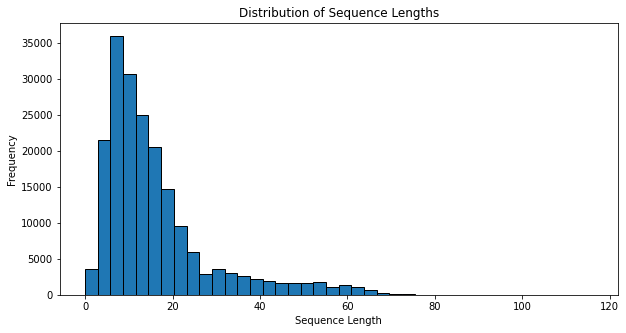

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(tokens_len, bins=40, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [17]:
# 상위 95% 문장의 길이
max_len = int(np.percentile(tokens_len, 95))
max_len

47

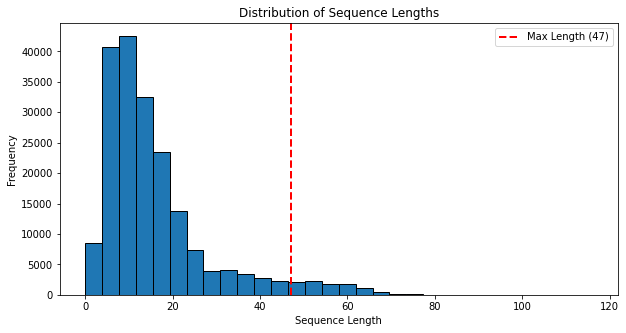

In [111]:
plt.figure(figsize=(10, 5))
plt.hist(tokens_len, bins=30, edgecolor='black')  
plt.axvline(max_len, color='red', linestyle='dashed', linewidth=2, label=f'Max Length ({max_len})')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [112]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [18]:
import numpy as np
import tensorflow as tf
import os

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                               padding='pre',
                                                               maxlen=max_len)

X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              padding='pre',
                                                              maxlen=max_len)

In [115]:
X_train_padded[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32,  74,
       919,   4,   4,  39, 228,  20,  33, 748], dtype=int32)

### 모델 구성 및 validation set 구성
- LSTM
- CNN
- Bi-LSTM

### validation set 구성

In [19]:
from sklearn.model_selection import train_test_split

# 훈련 데이터에서 20%를 검증 데이터로 분리
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_padded, y_train, test_size=0.2, random_state=42
)

X_train_final.shape, X_val.shape

((116945, 47), (29237, 47))

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [142]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200

#### LSTM

In [150]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    LSTM(8, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         1999400   
_________________________________________________________________
lstm_6 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,006,169
Trainable params: 2,006,169
Non-trainable params: 0
_________________________________________________________________


#### CNN

In [153]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [154]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Conv1D(16, kernel_size=5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(16, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 200)         1999400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          16016     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

#### Bi-LSTM

In [155]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    Bidirectional(LSTM(8, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 200)         1999400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 16)          13376     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,012,921
Trainable params: 2,012,921
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [123]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [156]:
batch_size = 512
epochs = 10

history_lstm = model_lstm.fit(X_train_final,
                              y_train_final,
                              validation_data=(X_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size,
                              callbacks=[early_stopping])

history_cnn = model_cnn.fit(X_train_final,
                            y_train_final,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping])

history_bilstm = model_bilstm.fit(X_train_final,
                                  y_train_final,
                                  validation_data=(X_val, y_val),
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  callbacks=[early_stopping])

Epoch 1/10
229/229 [==============================] - 3s 9ms/step - loss: 0.4609 - accuracy: 0.7898 - val_loss: 0.3534 - val_accuracy: 0.8483
Epoch 2/10
229/229 [==============================] - 2s 7ms/step - loss: 0.3194 - accuracy: 0.8655 - val_loss: 0.3368 - val_accuracy: 0.8528
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2833 - accuracy: 0.8823 - val_loss: 0.3356 - val_accuracy: 0.8561
Epoch 4/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2540 - accuracy: 0.8948 - val_loss: 0.3364 - val_accuracy: 0.8548
Epoch 5/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2276 - accuracy: 0.9072 - val_loss: 0.3589 - val_accuracy: 0.8571
Epoch 6/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2037 - accuracy: 0.9184 - val_loss: 0.3680 - val_accuracy: 0.8526
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.1829 - accuracy: 0.9289 - val_loss: 0.3990 - val_accuracy: 0.8542
Epoch 

### Loss, Accuracy 그래프 시각화

In [157]:
X_test_padded, y_test

(array([[   0,    0,    0, ...,    0,  832,  130],
        [   0,    0,    0, ...,    0,    0,    3],
        [   0,    0,    0, ..., 3557,   73,  917],
        ...,
        [   0,    0,    0, ...,    8,   12, 3424],
        [   0,    0,    0, ...,   67,  323,   43],
        [   0,    0,    0, ...,  179,   63, 1058]], dtype=int32),
 array([1, 0, 0, ..., 0, 0, 0]))

In [158]:
results_lstm = model_lstm.evaluate(X_test_padded,  y_test, verbose=2)  # (loss, accuracy)
results_cnn = model_cnn.evaluate(X_test_padded,  y_test, verbose=2)  # (loss, accuracy)
results_bilstm = model_bilstm.evaluate(X_test_padded,  y_test, verbose=2)  # (loss, accuracy)

1537/1537 - 3s - loss: 0.4303 - accuracy: 0.8478
1537/1537 - 3s - loss: 0.6521 - accuracy: 0.7815
1537/1537 - 4s - loss: 0.3987 - accuracy: 0.8505


In [159]:
print(f'LSTM    | Loss {results_lstm[0]} | Accuracy {results_lstm[1]}')
print(f'CNN     | Loss {results_cnn[0]} | Accuracy {results_cnn[1]}')
print(f'Bi-LSTM | Loss {results_bilstm[0]}  | Accuracy {results_bilstm[1]}')

LSTM    | Loss 0.430288165807724 | Accuracy 0.84781414270401
CNN     | Loss 0.6521397829055786 | Accuracy 0.7814756631851196
Bi-LSTM | Loss 0.39866903424263  | Accuracy 0.8505197763442993


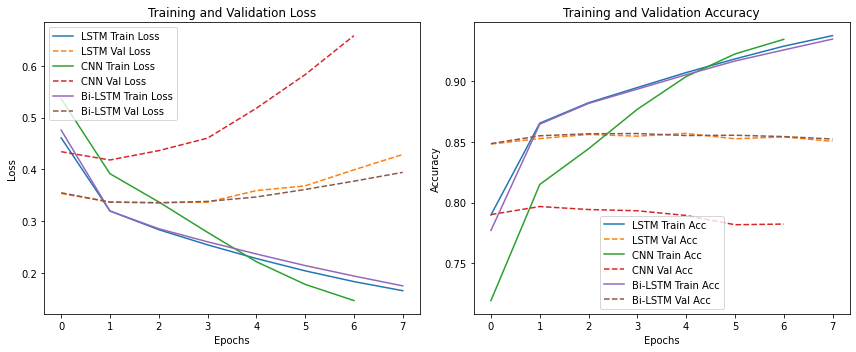

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', linestyle='dashed')
plt.plot(history_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss', linestyle='dashed')
plt.plot(history_bilstm.history['loss'], label='Bi-LSTM Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Bi-LSTM Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Acc', linestyle='dashed')
plt.plot(history_cnn.history['accuracy'], label='CNN Train Acc')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Acc', linestyle='dashed')
plt.plot(history_bilstm.history['accuracy'], label='Bi-LSTM Train Acc')
plt.plot(history_bilstm.history['val_accuracy'], label='Bi-LSTM Val Acc', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

**그래프 분석**  
- LSTM과 Bi-LSTM은 크게 성능 차이가 없는 것으로 보임
- 1D CNN은 빠르게 수렴하는 것 같지만 검증 성능이 떨어짐

### 학습된 Embedding 레이어 분석

In [138]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

임베딩 레이어 저장해서 벡터 확인해보자

In [161]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9997, 200)


In [162]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9997, 200)


In [163]:
embedding_layer = model_bilstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

word2vec_file_path_bilstm = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_bilstm.txt'
f = open(word2vec_file_path_bilstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model_bilstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(9997, 200)


In [164]:
word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

In [165]:
word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

In [166]:
word_vectors_bilstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_bilstm, binary=False)

유사도 확인

In [167]:
word_vectors_lstm.similar_by_word("재미")

[('긴장감', 0.6373536586761475),
 ('몰입', 0.6276328563690186),
 ('최강', 0.6152964234352112),
 ('이렇게', 0.6144139766693115),
 ('엄청난', 0.6123139262199402),
 ('이리', 0.6085885167121887),
 ('인권', 0.5925002694129944),
 ('넘', 0.591444730758667),
 ('운', 0.5908905267715454),
 ('노튼', 0.5883451700210571)]

In [168]:
word_vectors_cnn.similar_by_word("재미")

[('임파서블', 0.4044806659221649),
 ('피디', 0.39848268032073975),
 ('커플', 0.3909047842025757),
 ('.;', 0.37786364555358887),
 ('닿', 0.3731124699115753),
 ('드려요', 0.37242019176483154),
 ('조진웅', 0.3622530698776245),
 ('최강', 0.35570695996284485),
 ('언제', 0.3553158938884735),
 ('피터팬', 0.35514482855796814)]

In [169]:
word_vectors_bilstm.similar_by_word("재미")

[('그래서', 0.6963189840316772),
 ('완전', 0.6661420464515686),
 ('묘사', 0.6257102489471436),
 ('이리', 0.6241440176963806),
 ('씩', 0.619035542011261),
 ('박진감', 0.6137244701385498),
 ('매우', 0.6105475425720215),
 ('합리', 0.5998912453651428),
 ('잼', 0.5991782546043396),
 ('So', 0.5985656380653381)]

In [170]:
word_vectors_lstm.similar_by_word("실망")

[('노', 0.8906180262565613),
 ('가관', 0.8828310966491699),
 ('재미없', 0.882714033126831),
 ('망한', 0.8774597644805908),
 ('지루', 0.8772383332252502),
 ('차라리', 0.8761706948280334),
 ('어색', 0.8721854090690613),
 ('억지', 0.8703632354736328),
 ('낚였', 0.8673258423805237),
 ('졸린', 0.8639302253723145)]

In [171]:
word_vectors_cnn.similar_by_word("실망")

[('심한', 0.684215784072876),
 ('재미없', 0.6755714416503906),
 ('기황후', 0.6731027960777283),
 ('어수선', 0.6725926399230957),
 ('지저분', 0.6678945422172546),
 ('활극', 0.6648173928260803),
 ('쓰레기', 0.6624926328659058),
 ('거북', 0.659278392791748),
 ('억지', 0.6534460783004761),
 ('돈', 0.6527618765830994)]

In [172]:
word_vectors_bilstm.similar_by_word("실망")

[('왜곡', 0.8664616346359253),
 ('지루', 0.8633233308792114),
 ('쓰레기', 0.8575308322906494),
 ('그나마', 0.8535743355751038),
 ('과하', 0.8434015512466431),
 ('엎', 0.8371464014053345),
 ('노', 0.8314625024795532),
 ('배슬기', 0.8301792144775391),
 ('아까', 0.828586220741272),
 ('별루', 0.8269507884979248)]

- 그래프 상으로는 Bi-LSTM이 LSTM 보다 아아아아아주 조금 나았는데, 비슷한 단어를 출력해보니 LSTM 결과가 더 마음에 듦
- 긍정적인 것 보다 부정적인 단어들이 더 잘 맞아 떨어지는 것 같네

### 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 파일 [다운로드](https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg)

In [180]:
!ls /aiffel/aiffel/sentiment_classification/data/

GoogleNews-vectors-negative300.bin.gz  ratings_train.txt    word2vec_lstm.txt
ko.bin				       word2vec_bilstm.txt  word2vec.txt
ratings_test.txt		       word2vec_cnn.txt


In [181]:
from gensim.models import Word2Vec

word2vec_korean_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_word2vec = Word2Vec.load(word2vec_korean_path)

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

- 에러
  - AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>
- 원인
  - gensim의 버전 문제 때문
- 해결 방법
  - `pip install --upgrade gensim==3.8.3`
- [참고](https://iambeginnerdeveloper.tistory.com/41)

In [182]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 23.4 MB 4.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=c7440edaa9ccfa0524a7a2ef2e01c9868e6babf00eb5b86eb05ca22c44176878
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [4]:
import gensim
print(gensim.__version__)

import pandas as pd
import numpy as np
import tensorflow as tf
import os

3.8.3


In [5]:
from gensim.models import Word2Vec

word2vec_korean_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_word2vec = Word2Vec.load(word2vec_korean_path)

In [7]:
vector = ko_word2vec.wv.most_similar("재미")
vector

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [21]:
vocab_size = len(word_to_index)
word_vector_dim = ko_word2vec.wv.vectors.shape[1]
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec:
        embedding_matrix[i] = ko_word2vec[index_to_word[i]]

/tmp/ipykernel_772/2989352006.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_word2vec:
/tmp/ipykernel_772/2989352006.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_word2vec[index_to_word[i]]


In [22]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = len(word_to_index)  # 어휘 사전의 크기: 10000개 단어
word_vector_dim = 200

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=max_len, input_shape=(None,)),
    LSTM(8, return_sequences=False),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         1999400   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,169
Trainable params: 2,006,169
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [25]:
batch_size = 512
epochs = 10

history = model_lstm.fit(X_train_final,
                         y_train_final,
                         validation_data=(X_val, y_val),
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[early_stopping])

Epoch 1/10
229/229 [==============================] - 6s 9ms/step - loss: 0.4552 - accuracy: 0.8027 - val_loss: 0.3635 - val_accuracy: 0.8416
Epoch 2/10
229/229 [==============================] - 2s 7ms/step - loss: 0.3211 - accuracy: 0.8642 - val_loss: 0.3406 - val_accuracy: 0.8530
Epoch 3/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2890 - accuracy: 0.8776 - val_loss: 0.3416 - val_accuracy: 0.8536
Epoch 4/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2650 - accuracy: 0.8885 - val_loss: 0.3478 - val_accuracy: 0.8532
Epoch 5/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2433 - accuracy: 0.8990 - val_loss: 0.3632 - val_accuracy: 0.8513
Epoch 6/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2257 - accuracy: 0.9070 - val_loss: 0.3736 - val_accuracy: 0.8506
Epoch 7/10
229/229 [==============================] - 2s 7ms/step - loss: 0.2102 - accuracy: 0.9146 - val_loss: 0.4026 - val_accuracy: 0.8488
Epoch 

In [27]:
results = model_lstm.evaluate(X_test_padded,  y_test, verbose=2)  # (loss, accuracy)

1537/1537 - 3s - loss: 0.4050 - accuracy: 0.8462


In [28]:
print(f'LSTM - Word2Vec | Loss {results[0]} | Accuracy {results[1]}')

LSTM - Word2Vec | Loss 0.40503159165382385 | Accuracy 0.8461866974830627


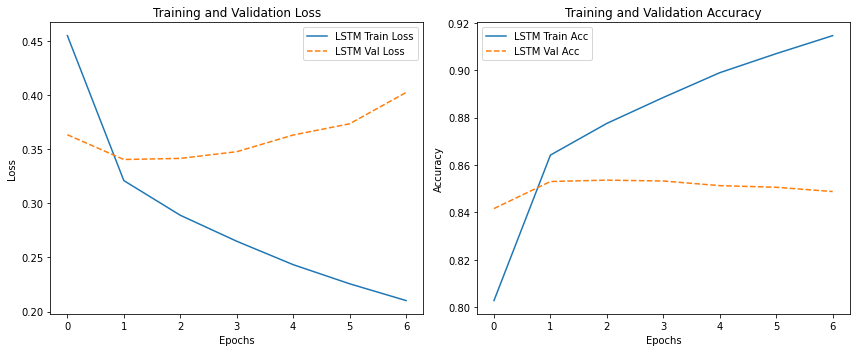

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='LSTM Train Acc')
plt.plot(history.history['val_accuracy'], label='LSTM Val Acc', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [31]:
ko_word2vec.similar_by_word("재미")

/tmp/ipykernel_772/3483129622.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [32]:
ko_word2vec.similar_by_word("실망")

/tmp/ipykernel_772/1535351898.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_word2vec.similar_by_word("실망")


[('당황', 0.7591220140457153),
 ('경악', 0.6881837248802185),
 ('분개', 0.6751235723495483),
 ('분노', 0.6750859022140503),
 ('격분', 0.647419810295105),
 ('감동', 0.6267645955085754),
 ('감탄', 0.6222271919250488),
 ('원망', 0.6156655550003052),
 ('조심', 0.6145114898681641),
 ('감복', 0.6109203696250916)]

#### 성능 비교 
LSTM            | Loss 0.430288165807724 | Accuracy 0.84781414270401  

LSTM - Word2Vec | Loss 0.40503159165382385 | Accuracy 0.8461866974830627  
  
- 기존 LSTM 모델을 활용하여 재학습
- Loss는 0.03, Accuracy는 0.001 정도 좋아짐
- 둘 다 부정적인 단어는 잘 찾아냄

### 회고
1. 모델을 구성할 때 유닛 사이즈를 크게 하고 층을 조금만 줬었는데 수렴하지 않았음
   - 유닛 사이즈를 줄이고 층을 조금 늘렸더니 좀 나아진 듯
2. 이번에는 시간이 없어서 함수화를 못 해서 아쉽..
3. 흥미로웠던 부분은 미리 학습된 임베딩 모델을 사용했을 때 '재미'의 비슷한 단어로 '비애'와 '향수'도 포함되어 있음
   ![pos_words.png](./images/pos_words.png)